# Random Forest with Earth Engine

## Importar pacotes

In [1]:
import geopandas as gpd
import pandas as pd

import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

import ee
import geemap
import json

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# importar dados

In [7]:
# df = pd.read_csv("C:/Users/LarissaVieiraValadão/Downloads/clean_min_data.csv").drop(['Unnamed: 0'],axis=1)
# df = pd.read_csv('C:/Users/l_v_v/Documents/GitHub/py6s_harmonize_sample/datasets/Landsat Sampling/Merged Landsat Data/Drop Outlier Data/clean_min_data.csv').drop(['Unnamed: 0'],axis=1)
df = pd.read_csv('/content/drive/MyDrive/CURUAI_PROCESS/clean_min_data.csv').drop(['Unnamed: 0'],axis=1)
df.columns

Index(['CHLOROPHYLL', 'CHLOROPHYLL_A', 'CHLOROPHYLL_B', 'CLOUD_COVER',
       'DEPTH_CLASS', 'DOC', 'ID', 'LATITUDE', 'LOCATION', 'LONGITUDE',
       'MISSION', 'N_TOTAL', 'N_TOTAL_DISSOLVED', 'POC', 'P_ORGANIC',
       'P_TOTAL', 'SAMPLE_SITE', 'SAMPLING_DEPTH', 'SILICA', 'SPM', 'TOC',
       'TOTAL_DEPTH', 'TURBIDITY', 'WATER_PERIOD', 'blue_max', 'blue_mean',
       'blue_median', 'blue_min', 'blue_stdDev', 'count_pixel', 'datetime',
       'dif_date_point', 'green_max', 'green_mean', 'green_median',
       'green_min', 'green_stdDev', 'img_date', 'nir_max', 'nir_mean',
       'nir_median', 'nir_min', 'nir_stdDev', 'red_max', 'red_mean',
       'red_median', 'red_min', 'red_stdDev', 'system_index',
       'dif_date_point_abs', 'satellite'],
      dtype='object')

In [8]:
df = df[['SPM','blue_mean', 'LATITUDE', 'LONGITUDE',
       'green_mean',
       'nir_mean',
       'red_mean',
       'datetime',
       'WATER_PERIOD']].copy()
# retirar valores em branco
df = df.dropna()
df.isna().sum()

,0
SPM,0
blue_mean,0
LATITUDE,0
LONGITUDE,0
green_mean,0
nir_mean,0
red_mean,0
datetime,0
WATER_PERIOD,0


In [10]:
#transform dataframe in a geodataframe (geometry column with point location)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE),
    crs="EPSG:4326"
)
gdf.head()

,SPM,blue_mean,LATITUDE,LONGITUDE,green_mean,nir_mean,red_mean,datetime,WATER_PERIOD,geometry
0,34.4,0.016988,-2.196960,-55.299530,0.027905,0.016161,0.036151,2013-03-09 11:20:00,R,POINT (-55.29953 -2.19696)
1,44.4,0.017570,-2.221738,-55.270194,0.029232,0.013234,0.034852,2013-03-09 13:00:00,R,POINT (-55.27019 -2.22174)
2,44.8,0.014560,-2.209570,-55.347110,0.020075,0.010206,0.024131,2013-03-09 14:35:00,R,POINT (-55.34711 -2.20957)
3,45.2,0.031565,-2.262023,-55.456187,0.039040,0.020332,0.043538,2013-03-11 08:00:00,R,POINT (-55.45619 -2.26202)
4,39.2,0.021785,-2.133265,-55.488798,0.032779,0.014011,0.038842,2013-03-11 13:00:00,R,POINT (-55.4888 -2.13326)


In [11]:
##Convert geodataframe to json - necessary to be read in GEE
dataset_json = gdf.to_json()

In [12]:
#load and select the features of the json data
reg_data = json.loads(dataset_json)
reg_data = reg_data['features']
# data_points

In [13]:
##transform json in in gee object = feature collection
reg_data = ee.FeatureCollection(reg_data)
print(reg_data.size().getInfo())

187


## Treinar e fazer tunning do algoritmo

In [14]:
predictors  = ['blue_mean','green_mean','red_mean','nir_mean']
predicted = 'SPM'
numTreesList = ee.List.sequence(200, 500, 100)
maxNodesList = ee.List([None,2,5,10])

In [15]:
def calculateRmse (model) :
  classified = reg_data.classify(classifier= model,
  outputName='SPM_predicted')
  observed = ee.Array(classified.aggregate_array('SPM'));
  predicted = ee.Array(classified.aggregate_array('SPM_predicted'));
  rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0]);
  return rmse

In [23]:
# // Tuning Multiple Parameters
classifiers_list = ee.FeatureCollection(numTreesList.map(lambda numtrees: maxNodesList.map(lambda maxnodes: ee.Feature(None,{
  'numberOfTrees':numtrees,
  'maxNodes':maxnodes,
  'seed':100,
  'rmse':calculateRmse(ee.Classifier.smileRandomForest(
       numberOfTrees= numtrees,
       maxNodes= maxnodes,
       seed=100
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      )),
  }))).flatten())
classifiers_list

In [24]:
resultFcSorted = classifiers_list.sort('rmse');
lowest_rmse_feature = resultFcSorted.first();
lowestRMSE = lowest_rmse_feature.getNumber('rmse');
optimalNumTrees = lowest_rmse_feature.getNumber('numberOfTrees');
optimalmaxNodes = lowest_rmse_feature.getNumber('maxNodes');

lowest_rmse_feature

In [25]:
classifier = ee.Classifier.smileRandomForest(
  numberOfTrees= optimalNumTrees,
  maxNodes= optimalmaxNodes,
  seed=150).setOutputMode('REGRESSION').train(
    features= reg_data,
    classProperty= 'SPM',
    inputProperties= predictors
  )


In [31]:
def get_relativeImportance(key, val):
  return (ee.Number(val)).divide(sum)

In [37]:
# // Calculate variable importance
importance = ee.Dictionary(classifier.explain().get('importance'))

# // Calculate relative importance
sum = importance.values().reduce(ee.Reducer.sum())

relativeImportance = importance.map(get_relativeImportance).getInfo()
relativeImportance

{'blue_mean': 0.16014414040011316,
 'green_mean': 0.20488698807187408,
 'nir_mean': 0.4010055289823335,
 'red_mean': 0.23396334254567927}

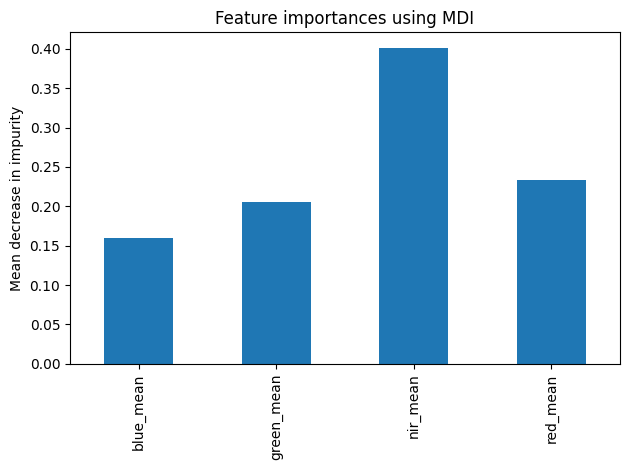

In [49]:
forest_importances = pd.Series(relativeImportance.values(), index=relativeImportance.keys())

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Relative Importance")
fig.tight_layout()

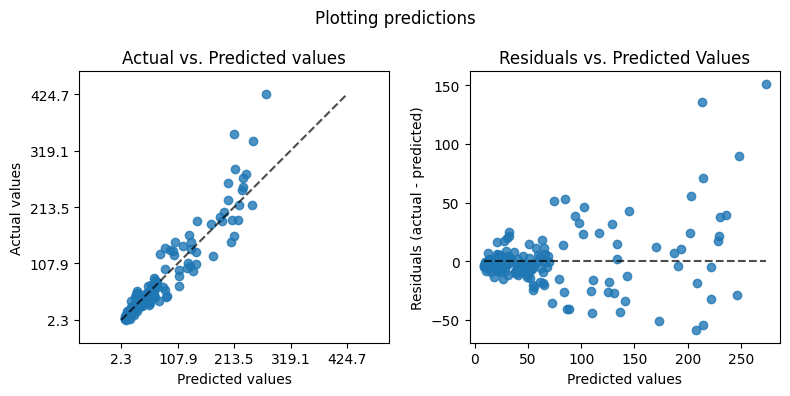

In [29]:
classified_points = geemap.ee_to_df(reg_data.classify(classifier= classifier,
  outputName='SPM_predicted'))

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    classified_points['SPM'],
    y_pred=classified_points['SPM_predicted'],
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    classified_points['SPM'],
    y_pred=classified_points['SPM_predicted'],
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

<Axes: xlabel='datetime', ylabel='SPM_predicted'>

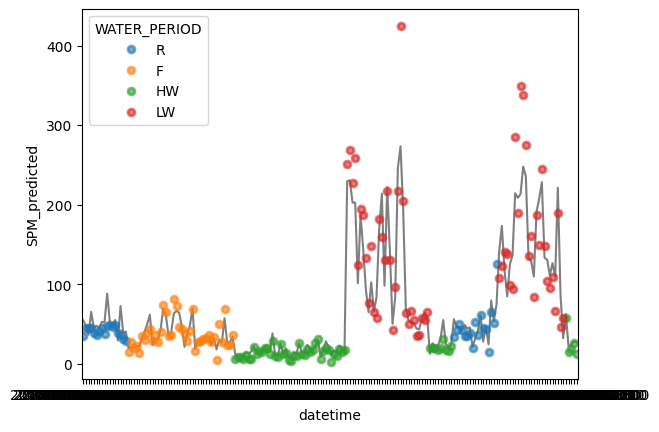

In [30]:
sns.lineplot(data=classified_points, x ='datetime',y= 'SPM_predicted',color='gray')
sns.pointplot(data=classified_points, x ='datetime',y= 'SPM', linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

# Exportar o classificador como asset

In [50]:
# Create an export classifier task to run.
asset_id = 'projects/ee-curuai/assets/RF_regressor'  # <> modify these
task = ee.batch.Export.classifier.toAsset(
    classifier=classifier,
    description='classifier_export',
    assetId=asset_id
)
task.start()